# Semantic Segmentation of Anatomical ROIs from Chest CT Scans
This workflow is extended from the methodology of segmentation using KMeans clustering and morphology methods elucidated in the [paper by Rim et al](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8070040/). The paper is implemented in the first directory and the results are analyzed for the dataset we work on. 
- During the generation of the convex hull for the foreground mask, much of the background area outside the ribs was enclosed in the hull. This resulted in area outside the ribs filtered along with the lungs in the lung mask.
- The initial and final slices of CT scans reported inaccurate results for lung and heart segmentations.
    - In the initial slices of CT scans of the chest, the lungs occupied little area, and the trachea was segmented along with the lungs in the lung mask. This caused the convex hull of the lung mask to occupy a triangular region.
    - The region leftover after the lung mask was subtracted from the convex hull of the lung mask was designated as the heart. This is wrong, as the heart is not seen in the original image in the initial slices.

Therefore, we present an alternative to segment anatomically meaningful regions of interest more effectively in all cases of slices of CT scans.
## 1. Import Libs & Acquire Data

In [1]:
import os
import cv2 
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from sklearn.cluster import KMeans
from skimage.morphology import erosion, opening, closing, square, \
                               disk, convex_hull_image, remove_small_holes
from skimage.measure import label, regionprops

from skimage.filters import sobel
from skimage.feature import canny
from scipy import ndimage as ndi
from skimage.segmentation import watershed
    
SMALL_FONT = 13
MEDIUM_FONT = 15
LARGE_FONT = 18

plt.rc('font', size=SMALL_FONT)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_FONT)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_FONT)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_FONT)   # legend fontsize
plt.rc('figure', titlesize=LARGE_FONT)   # fontsize of the figure title

plt.rcParams["figure.figsize"] = (10, 5)

In [2]:
def readSortedSlices(path):
    
    slices = []
    for s in os.listdir(path):
        slices.append(path[3:] + '/' + s)       
    slices.sort(key = lambda s: int(s[s.find('_') + 1 : s.find('.')]))
    ID = slices[0][slices[0].find('/') + 1 : slices[0].find('_')]
    print('CT scan of Patient %s consists of %d slices.' % (ID, len(slices)))  
    return (slices, ID)

def getSliceImages(slices):
    
    return list(map(readImg, slices))

def readImg(path, showOutput=0):
    
    img = cv2.imread('../' + path)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    if showOutput:
        plt.title('A CT Scan Image Slice')
        plt.imshow(img, cmap='gray')
    return img

In [3]:
slices, PatientID = readSortedSlices('../sample-dataset')
sliceImgs = getSliceImages(slices)

CT scan of Patient ID00007637202177411956430 consists of 30 slices.


Image Dimensions: (512, 512)


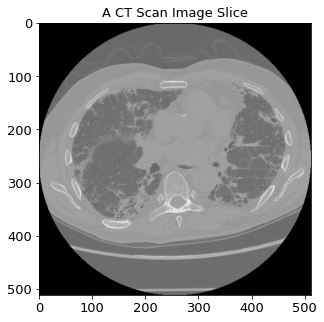

In [4]:
# Select a sample slice to work with
im = readImg('sample-dataset/ID00007637202177411956430_16.jpg', showOutput=1)
print('Image Dimensions:', im.shape)

## 2. Preprocessing CT Images

In [5]:
def imgKMeans(img, K, showOutput=0, showHistogram=0):
    '''
    Apply KMeans on an image with the number of clusters K
    Input: Image, Number of clusters K
    Output: Dictionary of cluster center labels and points, Output segmented image
    '''

    imgflat = np.reshape(img, img.shape[0] * img.shape[1]).reshape(-1, 1)
        
    kmeans = KMeans(n_clusters=K, verbose=0)
    
    kmmodel = kmeans.fit(imgflat)
    
    labels = kmmodel.labels_
    centers = kmmodel.cluster_centers_
    center_labels = dict(zip(np.arange(K), centers))
    
    output = np.array([center_labels[label] for label in labels])
    output = output.reshape(img.shape[0], img.shape[1]).astype(int)
    
    if showOutput:

        fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
        axes = axes.ravel()

        axes[0].imshow(img, cmap='gray')
        axes[0].set_title('Original Image')

        axes[1].imshow(output)
        axes[1].set_title('Image after KMeans (K = ' + str(K) + ')')
    
    return center_labels, output

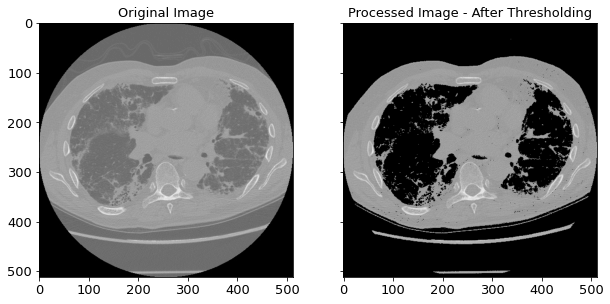

In [6]:
def preprocessImage(img, showOutput=0):
    '''
    Preprocess the image by applying truncated thresholding using KMeans
    Input: Image
    Output: Preprocessed image, threshold value
    '''
    centroids, segmented_img = imgKMeans(img, 3, showOutput=0)
    
    sorted_center_values = sorted([i[0] for i in centroids.values()])
    threshold = (sorted_center_values[-1] + sorted_center_values[-2]) / 2
    
    retval, procImg = cv2.threshold(img, threshold, 255, cv2.THRESH_TOZERO) 
    
    if showOutput:
        
        fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
        axes = axes.ravel()

        axes[0].imshow(img, cmap='gray')
        axes[0].set_title('Original Image')

        axes[1].imshow(procImg, cmap='gray')
        axes[1].set_title('Processed Image - After Thresholding')
    
    return procImg, threshold

procImg, fg_threshold = preprocessImage(im, showOutput=1)

## 3. Foreground Mask Generation Using Edge-based Segmentation

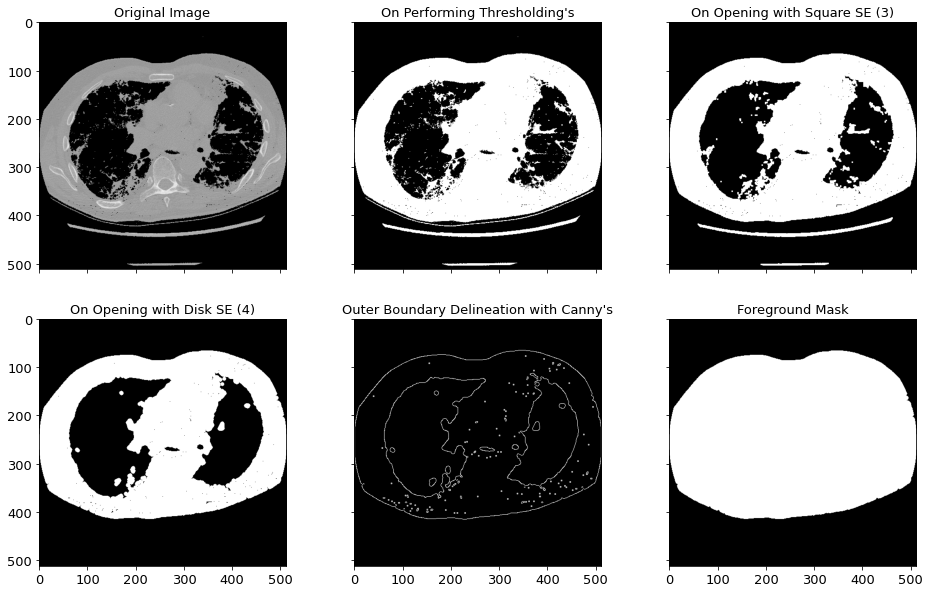

In [7]:
def getForegroundMask(img, fg_threshold, showOutput=0):
    
    retval, init_fg_mask = cv2.threshold(img, fg_threshold, 255, cv2.THRESH_BINARY)

    # Morphological operations to clean the mask
    fg_mask_opened = opening(init_fg_mask, square(3))
    fg_mask_opened2 = opening(fg_mask_opened, disk(4))
    
    # Perform edge-based segmentation of the foreground...
    
    # Detect contours that delineate the foreground with the Canny edge detector
    edges = canny(fg_mask_opened2) # Background is uniform - edges are on the boundary/inside ROI
    
    # Fill the inner part of the boundary using morphology ops
    fg_mask = ndi.binary_fill_holes(fg_mask_opened2)
    
    # Plot all steps
    if showOutput:
        fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(16, 10))
        axes = axes.ravel()

        axes[0].set_title('Original Image')
        axes[0].imshow(img, cmap='gray')
        axes[1].set_title('On Performing Thresholding\'s')
        axes[1].imshow(init_fg_mask, cmap='gray')
        axes[2].set_title('On Opening with Square SE (3)')
        axes[2].imshow(fg_mask_opened, cmap='gray')
        axes[3].set_title('On Opening with Disk SE (4)')
        axes[3].imshow(fg_mask_opened2, cmap='gray')
        axes[4].set_title('Outer Boundary Delineation with Canny\'s')
        axes[4].imshow(edges, cmap='gray')
        axes[5].set_title('Foreground Mask')
        axes[5].imshow(fg_mask, cmap='gray')

    return fg_mask

fg_mask = getForegroundMask(procImg, fg_threshold, showOutput=1)

## 4. Lung & Trachea Mask Generation Using Region Properties

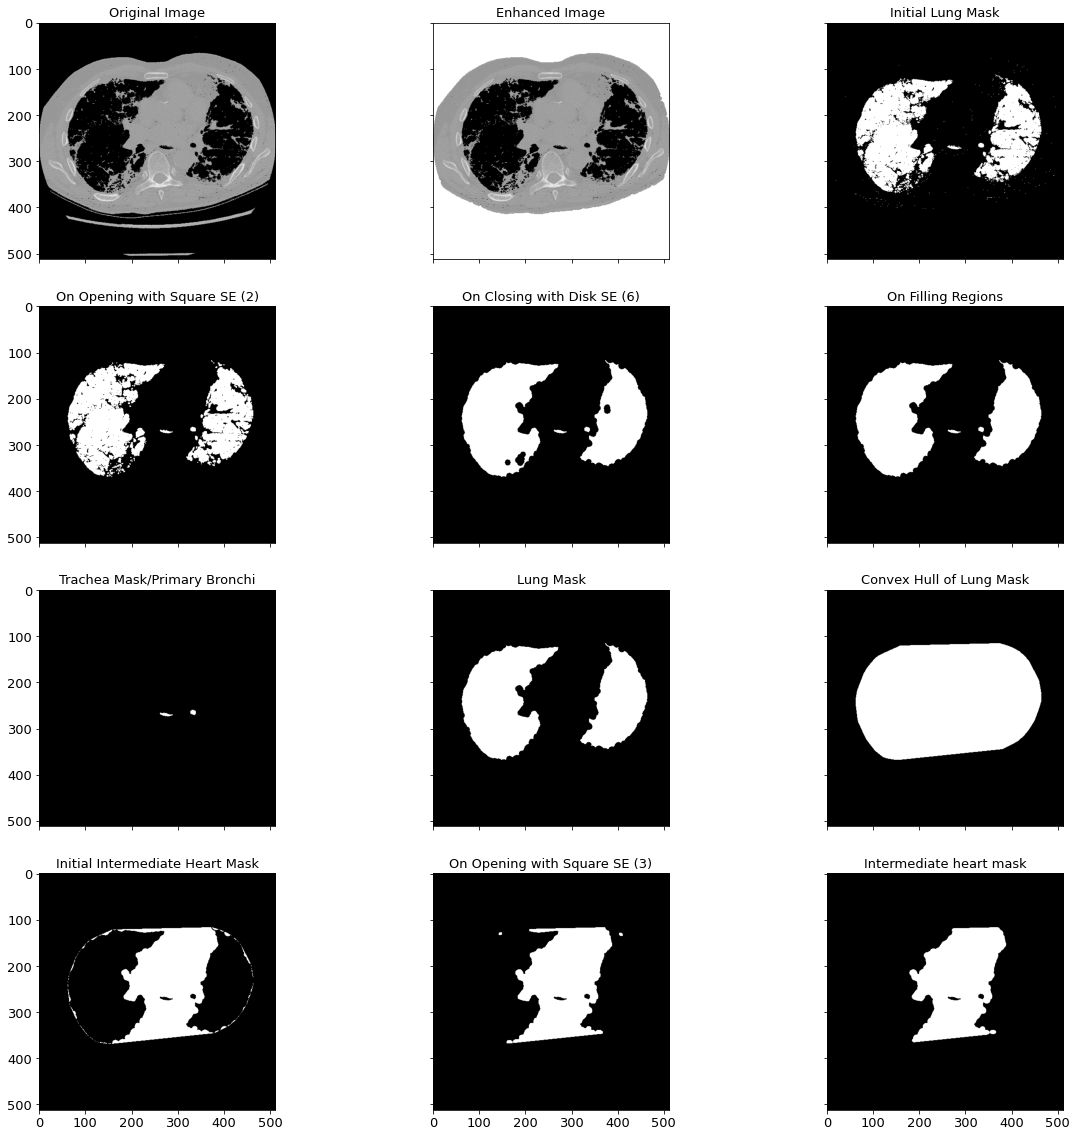

In [8]:
def getLungTracheaMasks(img, fg_mask, fg_threshold, showOutput=0):
    
    # Distinguish black pixels of the background from those of the lungs
    enhanced = img.copy()
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            
            if fg_mask[i][j] == 0:
                enhanced[i][j] = 255
         
    # Extract lungs from the foreground mask
    retval, initial_lung_mask = cv2.threshold(enhanced, fg_threshold, 255, cv2.THRESH_BINARY_INV) 
    
    # Clean up the lung mask with morphological operations
    lung_mask_op = opening(initial_lung_mask, square(2))
    lung_mask_opcl = closing(lung_mask_op, disk(6))
    lung_mask_opclrm = ndi.binary_fill_holes(lung_mask_opcl)

    # Get connected components of the segmented image and label them
    label_img = label(lung_mask_opclrm)
    lung_regions = regionprops(label_img)
    
    # Upon experimentation: areas of regions < 1500 are wind pipe structures
    trachea_labels = []
    for i in lung_regions:
        if i.area < 1500:
            trachea_labels.append(i.label)
            
    # Create trachea mask as a summation of all those regions
    trachea_mask = np.zeros(img.shape, dtype=np.uint8)
    for row in range(label_img.shape[0]):
        for col in range(label_img.shape[1]):
            if label_img[row][col] in trachea_labels:
                trachea_mask[row][col] = 255
            
    # Lung mask is made of all the other regions
    lung_mask = lung_mask_opclrm * np.invert(trachea_mask) 
    
    # Lung mask is all black? Convex hull set to 0, since convex hull op on empty img errors out
    if sum(sum(lung_mask)) > 0:
        ch_lung_mask = convex_hull_image(lung_mask)
    else:
        ch_lung_mask = lung_mask.copy()
    
    
    initial_int_heart_mask = ch_lung_mask * np.invert(lung_mask) * np.invert(trachea_mask)
    
    int_heart_mask_op1 = opening(initial_int_heart_mask, square(5))
    int_heart_mask_op2 = opening(int_heart_mask_op1, disk(4))
    
    heart_label_img = label(int_heart_mask_op2)
    heart_regions = regionprops(heart_label_img)
    
    areas = {}
    for i in heart_regions:
        areas[i.label] = i.area
    
    if areas:
        heart_label = max(areas, key=areas.get)
        int_heart_mask = np.where(heart_label_img==heart_label, np.uint8(255), np.uint8(0))
    else:
        int_heart_mask = np.zeros(img.shape, dtype=np.uint8)
        
    if showOutput:
        
        fig, axes = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(20, 20))
        axes = axes.ravel()

        axes[0].set_title('Original Image')
        axes[0].imshow(img, cmap='gray')

        axes[1].set_title('Enhanced Image')
        axes[1].imshow(enhanced, cmap='gray')

        axes[2].set_title('Initial Lung Mask')
        axes[2].imshow(initial_lung_mask, cmap='gray')

        axes[3].set_title('On Opening with Square SE (2)')
        axes[3].imshow(lung_mask_op, cmap='gray')

        axes[4].set_title('On Closing with Disk SE (6)')
        axes[4].imshow(lung_mask_opcl, cmap='gray')

        axes[5].set_title('On Filling Regions')
        axes[5].imshow(lung_mask_opclrm, cmap='gray')

        axes[6].set_title('Trachea Mask/Primary Bronchi')
        axes[6].imshow(trachea_mask, cmap='gray')

        axes[7].set_title('Lung Mask')
        axes[7].imshow(lung_mask, cmap='gray')

        axes[8].set_title('Convex Hull of Lung Mask')
        axes[8].imshow(ch_lung_mask, cmap='gray')

        axes[9].set_title('Initial Intermediate Heart Mask')
        axes[9].imshow(initial_int_heart_mask, cmap='gray')

        axes[10].set_title('On Opening with Square SE (3)')
        axes[10].imshow(int_heart_mask_op1, cmap='gray')

        axes[11].set_title('Intermediate heart mask')
        axes[11].imshow(int_heart_mask, cmap='gray')
    
    return trachea_mask, lung_mask, ch_lung_mask, int_heart_mask

trachea_mask, lung_mask, ch_lung_mask, int_heart_mask = getLungTracheaMasks(procImg, 
                                                                          fg_mask, 
                                                                          fg_threshold, 
                                                                          showOutput=1)

## 5. Spine Mask and Heart Mask Generation

In [23]:
def chullSpineMask(img, int_heart_mask, showOutput=0):
    
    # If no heart
    if not int_heart_mask.any():
        return int_heart_mask, int_heart_mask
    
    int_heart_pixel = img.copy()
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if int_heart_mask[i][j] == 0:
                int_heart_pixel[i][j] = 0
                
    centroids, segmented_heart_img = imgKMeans(int_heart_pixel, 3, showOutput=0)
    
    spine_threshold = (max(centroids.values()))[0]

    retval, initial_spine_mask = cv2.threshold(int_heart_pixel, spine_threshold, 255, cv2.THRESH_BINARY) 
    
    bone_mask = closing(initial_spine_mask, disk(20))  
    
    label_spine = label(bone_mask)
    spine_regions = regionprops(label_spine)

    # Assumption: The spine's area is greater than that of any calcium deposits
    labels = []
    areas = {}
    geometric_measures = {}
    for i in spine_regions:
        labels.append(i.label)
        areas[i.label] = i.area
        geometric_measures[i.label] = [i.centroid, i.orientation, i.axis_major_length]
    
    spine_label = max(areas, key=areas.get)
    labels.remove(spine_label)
    spine_mask = np.where(label_spine==spine_label, np.uint8(255), np.uint8(0))
    
#     if labels:
#         calcium_deposit_mask = np.where(label_spine==labels[0], np.uint8(255), np.uint8(0))
#     else:
#         calcium_deposit_mask = np.zeros(img.shape, dtype=np.uint8)
    
    label_heart = label(int_heart_mask)
    heart_regions = regionprops(label_heart)
    heart_region_area = heart_regions[0].area
    spine_region_area = areas[spine_label] 
    
    frac_heart = (heart_region_area - spine_region_area)/heart_region_area
    
    if frac_heart < 0.5:
        heart_mask = np.zeros(img.shape, dtype=np.uint8)
        make_spine_mask = 0
    else:
        make_spine_mask = 1
        
        # Center point of the spine - get the centroid 
        y0, x0 = geometric_measures[spine_label][0]

        orientation = geometric_measures[spine_label][1]

        # Top-most point of the spine
        # top_most_coordinate = centroid - (slightly_more_than_half * axis_major_length * sin(angle))
        x2 = x0 - math.sin(orientation) * 0.6 * geometric_measures[spine_label][2]
        y2 = y0 - math.cos(orientation) * 0.6 * geometric_measures[spine_label][2]

        chull_spine_mask = spine_mask.copy()

        # Vertical axis
        for i in range(math.ceil(y2), img.shape[1]):

            if i > math.ceil(y0):
                # Horizontal axis
                for j in range(img.shape[0]):
                    chull_spine_mask[i][j] = 255
            else:
                # Horizontal axis
                for j in range(math.ceil(x0)):
                    chull_spine_mask[i][j] = 255


        heart_mask = int_heart_mask * np.invert(chull_spine_mask)
    
    if showOutput:
        
        fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))
        axes = axes.ravel()

        axes[0].set_title('Intermediate Heart Mask')
        axes[0].imshow(int_heart_mask, cmap='gray')

        axes[1].set_title('Intermediate Heart Segment')
        axes[1].imshow(int_heart_pixel, cmap='gray')
        
        axes[2].set_title('Intermediate Heart Segment on K-Means (K = 3)')
        axes[2].imshow(segmented_heart_img)

        axes[3].set_title('Spine Mask')
        axes[3].imshow(initial_spine_mask, cmap='gray')
        
        axes[4].set_title('On Closing with Disk SE (20)')
        axes[4].imshow(spine_mask, cmap='gray')
        
        axes[5].set_title('On Opening with Square SE (4)')
        axes[5].imshow(spine_mask, cmap='gray')
        
        axes[6].set_title('Centroid and uppermost point')
        axes[6].imshow(spine_mask, cmap='gray')
        
        if make_spine_mask:
            axes[6].plot((x0, x2), (y0, y2), '-r', linewidth=1.5)
            axes[6].plot(x0, y0, '.g', markersize=5)
            axes[6].plot(x2, y2, '.b', markersize=5)
        
            axes[7].set_title('Convex Hull of Spine Mask')
            axes[7].imshow(chull_spine_mask, cmap='gray')
        
        axes[8].set_title('Heart Mask')
        axes[8].imshow(heart_mask, cmap='gray')
        
    return spine_mask, heart_mask

Spine and heart: 0.8739940011285006 33673 4243


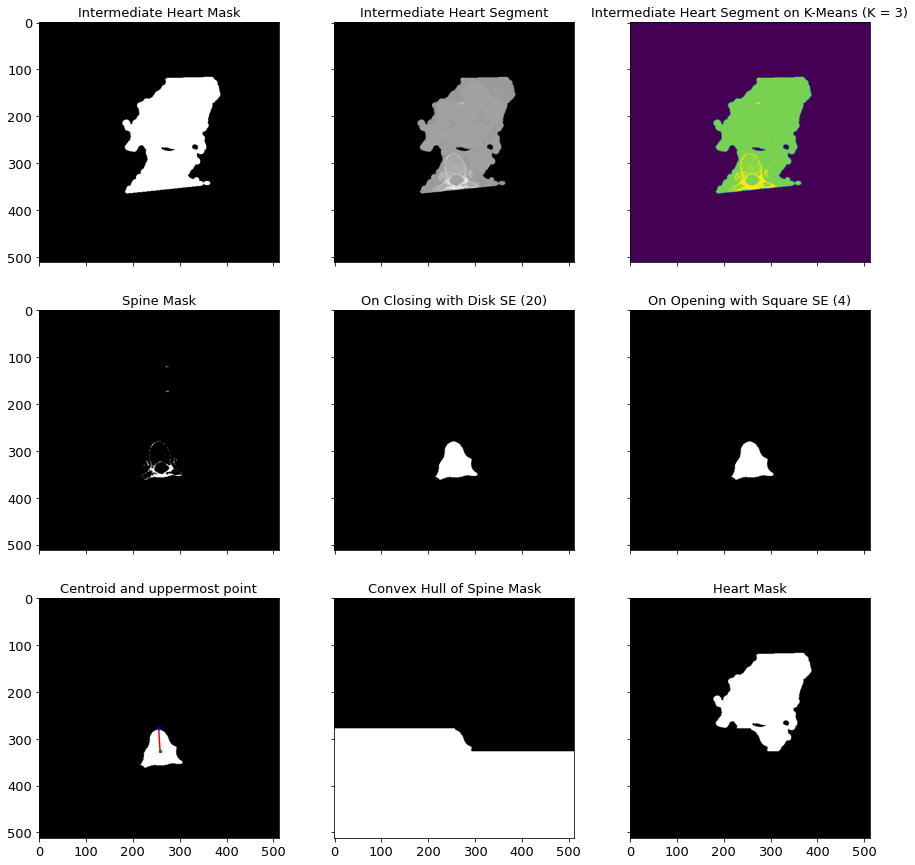

In [10]:
spine_mask, heart_mask = chullSpineMask(im, int_heart_mask, showOutput=1)

Text(0.5, 1.0, 'Heart Mask')

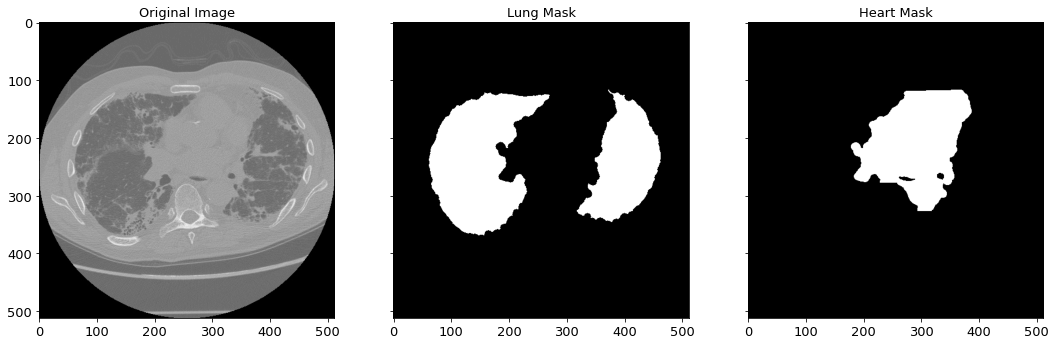

In [11]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(18, 6))
axes = axes.ravel()
axes[0].imshow(im, cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(lung_mask, cmap='gray')
axes[1].set_title('Lung Mask')
axes[2].imshow(heart_mask, cmap='gray')
axes[2].set_title('Heart Mask')

## 6. Segment Heart, Lungs and the Trachea

In [12]:
def segmentHeartLungsTrachea(img, heart_mask, lung_mask, trachea_mask, showOutput=0):

    seg_heart = cv2.bitwise_and(img, img, mask=heart_mask)
    seg_lungs = cv2.bitwise_and(img, img, mask=lung_mask)
    seg_trachea = cv2.bitwise_and(img, img, mask=trachea_mask)
    
    if showOutput:
        fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12, 6), sharex=True, sharey=False)
        
        ax1.set_title('Segmented Heart')
        ax1.imshow(seg_heart, cmap='gray')
        
        ax2.set_title('Segmented Lungs')
        ax2.imshow(seg_lungs, cmap='gray')
        
        ax3.set_title('Segmented Trachea')
        ax3.imshow(seg_trachea, cmap='gray')
        
    return seg_heart, seg_lungs, seg_trachea

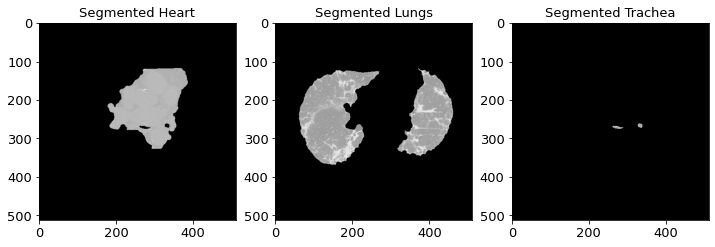

In [13]:
segmented_heart, segmented_lungs, segmented_trachea = segmentHeartLungsTrachea(im, 
                                                                               heart_mask, 
                                                                               lung_mask, 
                                                                               trachea_mask, 
                                                                               showOutput=1)

In [14]:
def applyMaskColor(mask, mask_color):
    
    masked = np.concatenate(([mask[ ... , np.newaxis] * color for color in mask_color]), axis=2)
    
    # Matplotlib expects color intensities to range from 0 to 1 if a float
    maxValue = np.amax(masked)
    minValue = np.amin(masked)

    # Therefore, scale the color image accordingly
    if maxValue - minValue == 0:
        return masked
    else:
        masked = masked / (maxValue - minValue)
    
    return masked

def getColoredMasks(img, heart_mask, lung_mask, trachea_mask, showOutput=0):
    heart_mask_color = np.array([256, 0, 0])
    lung_mask_color = np.array([0, 256, 0])
    trachea_mask_color = np.array([0, 0, 256])

    heart_colored = applyMaskColor(heart_mask, heart_mask_color)
    lung_colored = applyMaskColor(lung_mask, lung_mask_color)
    trachea_colored = applyMaskColor(trachea_mask, trachea_mask_color)
    
    colored_masks = heart_colored + lung_colored + trachea_colored

    if showOutput:
        fig, axes = plt.subplots(2, 2, figsize=(10, 10))
        ax = axes.ravel()
        
        ax[0].set_title("Original Image")
        ax[0].imshow(img, cmap='gray')
        ax[1].set_title("Heart Mask")
        ax[1].imshow(heart_colored)
        ax[2].set_title("Lung Mask")
        ax[2].imshow(lung_colored)
        ax[3].set_title("Masks")
        ax[3].imshow(colored_masks)
    
    return heart_colored, lung_colored, trachea_colored, colored_masks

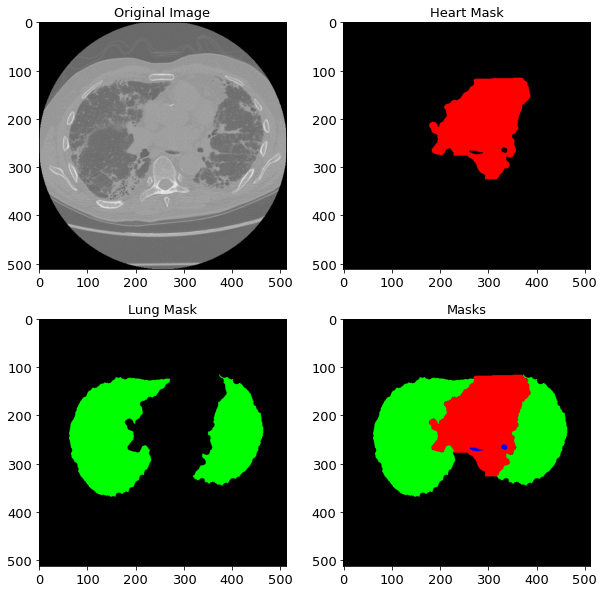

In [15]:
heart_colored, lung_colored, trachea_colored, colored_masks = getColoredMasks(im, heart_mask, lung_mask, trachea_mask, showOutput=1)